In [64]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [65]:
import os, sys

# Add to path the parent directory of this notebook dir

root_dir = os.path.dirname(
        os.path.dirname(os.path.realpath(".")))

sys.path.append(root_dir)

import yaml
import pandas as pd
import torch
import logging
import pickle

import numpy as np
from rl_envs_forge.envs.grid_world.grid_world import GridWorld
from common.src.simple_dqn_agent import AgentDQN


from common.src.visualize import draw_simple_gridworld, draw_gridworld_with_state_counts

from common.src.utils import create_random_policy, extract_V_from_Q_for_stochastic_policy, extract_V_from_Q, derive_policy_from_q_table
from common.src.policy_iteration import random_policy_evaluation_q_stochastic, policy_evaluation_v
from common.src.value_iteration import value_iteration_v, value_iteration_q
 

from common.src.distribution_src import ( 
                                         make_env,
                                         StandardizeWrapper, 
                                         random_select_starting_pos,
                                        randomize_walls_positions, 
                                        generate_train_test_split_with_valid_path,
                                        run_distribution_correction_experiment,
                                        compute_validation_bellmans_error,
                                        setup_dqn_agent,
                                        run_dqn_distribution_correction_experiment
                                        )

from common.src.experiment_utils import (
    setup_logger
)

In [66]:
def tuple_constructor(loader, node):
    return tuple(loader.construct_sequence(node))


def generic_constructor(loader, tag_suffix, node):
    if isinstance(node, yaml.MappingNode):
        # Attempt to handle unhashable keys by converting them to a string representation
        # This is a workaround and might need adjustment based on specific use cases
        return {
            str(loader.construct_object(key)): loader.construct_object(value)
            for key, value in node.value
        }
    elif isinstance(node, yaml.SequenceNode):
        return [loader.construct_object(child) for child in node.value]
    elif isinstance(node, yaml.ScalarNode):
        return loader.construct_scalar(node)


yaml.SafeLoader.add_constructor("tag:yaml.org,2002:python/tuple", tuple_constructor)
yaml.SafeLoader.add_multi_constructor("", generic_constructor)

In [67]:
def find_matching_paths(root_dir):
    """
    Finds all matching paths under the given root directory using os.scandir.

    Parameters:
    - root_dir: The root directory to start searching from.

    Returns:
    - A list of matching paths.
    """
    matching_paths = []

    def recursive_scan(dir_path):
        with os.scandir(dir_path) as entries:
            for entry in entries:
                if entry.is_dir():
                    if len(os.path.relpath(entry.path, root_dir).split(os.sep)) == 2:
                        matching_paths.append(entry.path)
                    recursive_scan(entry.path)

    recursive_scan(root_dir)
    return matching_paths

def read_yaml_files(paths):
    """
    Reads the post_config.yaml file from each directory in the given list of paths.

    Parameters:
    - paths: List of directories to search for post_config.yaml.

    Returns:
    - A dictionary where keys are the directory paths and values are the contents of post_config.yaml.
    """
    config_data = {}

    for path in paths:
        yaml_file = os.path.join(path, "post_cfg.yaml")
        if os.path.exists(yaml_file):
            with open(yaml_file, "r") as file:
                config_data[path] = yaml.safe_load(file)
        else:
            print(f"post_config.yaml not found in {path}")

    return config_data


def flatten_stats(stats_dict):
    """
    Flattens the nested episode frames statistics in the given dictionary.

    Parameters:
    - stats_dict: The dictionary containing the statistics.

    Returns:
    - A flattened dictionary containing the episode frames statistics.
    """
    flattened = {}
    for key, value in stats_dict["episode_frames"].items():
        flattened[f"episode_frames_{key}"] = value
    return flattened

def read_yaml_files(paths):
    """
    Reads the post_config.yaml file from each directory in the given list of paths.

    Parameters:
    - paths: List of directories to search for post_config.yaml.

    Returns:
    - A dictionary where keys are the directory paths and values are the contents of post_config.yaml.
    """
    config_data = {}

    for path in paths:
        yaml_file = os.path.join(path, "post_cfg.yaml")
        if os.path.exists(yaml_file):
            with open(yaml_file, "r") as file:
                config_data[path] = yaml.safe_load(file)
        else:
            print(f"post_config.yaml not found in {path}")

    return config_data


def flatten_stats(stats_dict):
    """
    Flattens the nested episode frames statistics in the given dictionary.

    Parameters:
    - stats_dict: The dictionary containing the statistics.

    Returns:
    - A flattened dictionary containing the episode frames statistics.
    """
    flattened = {}
    for key, value in stats_dict["episode_frames"].items():
        flattened[f"episode_frames_{key}"] = value
    return flattened

# Example usage
root_dir = (
    r"D:\Work\repos\phd-research\experiments\dqn\results\2024Jul10-231624_configs"
)
matching_paths = find_matching_paths(root_dir)
config_data = read_yaml_files(matching_paths)

In [68]:
config_data

{'D:\\Work\\repos\\phd-research\\experiments\\dqn\\results\\2024Jul10-231624_configs\\0000_replay_buffer.type_ReplayBuffer__agent_params.args_.epsilon.end_1.0__agent_params.args_.epsilon.start_1.0__agent_params.args_.hidden_size_16\\0': {'agent_params': {'agent': 'AgentDQN',
   'args': {'batch_size': 32,
    'epsilon': {'decay': 240000, 'end': 1.0, 'start': 1.0},
    'gamma': 0.9,
    'hidden_size': 16,
    'loss_fcn': 'mse_loss',
    'replay_start_size': 1000,
    'target_model_update_freq': 50,
    'train_step_cnt': 8000,
    'training_freq': 4,
    'validation_enabled': True,
    'validation_epsilon': 0.001,
    'validation_step_cnt': 8000}},
  'algorithm': 'default',
  'cfg_id': 0,
  'cols': 21,
  'episode_length_limit': 4000,
  'experiment': 'experiment_distributions',
  'experiment_arguments': {'agent_params': {'args': {'epsilon': {'end': 1.0,
      'start': 1.0},
     'hidden_size': 16}},
   'replay_buffer': {'type': 'ReplayBuffer'}},
  'full_title': '2024Jul10-231624_configs_re

In [69]:
for key in config_data:
    path = key
    config = config_data[key]
    break
path

'D:\\Work\\repos\\phd-research\\experiments\\dqn\\results\\2024Jul10-231624_configs\\0000_replay_buffer.type_ReplayBuffer__agent_params.args_.epsilon.end_1.0__agent_params.args_.epsilon.start_1.0__agent_params.args_.hidden_size_16\\0'

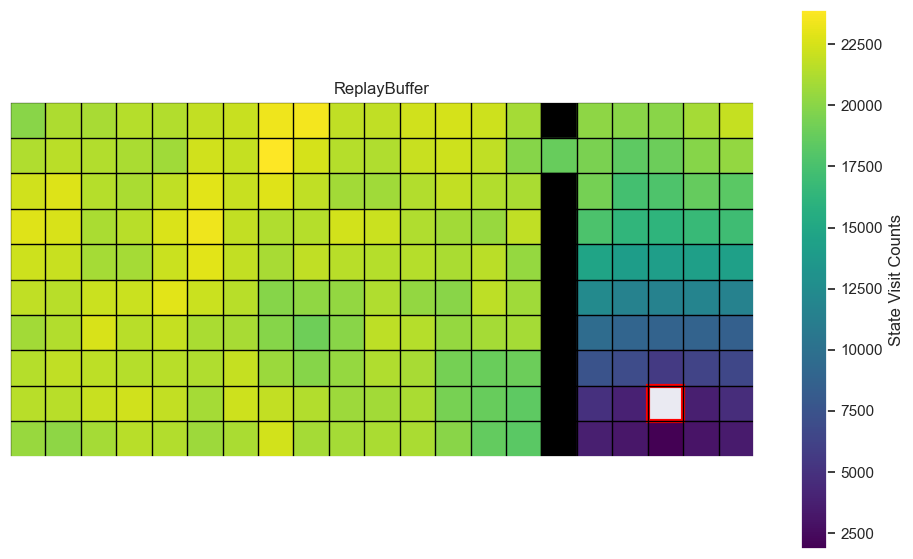

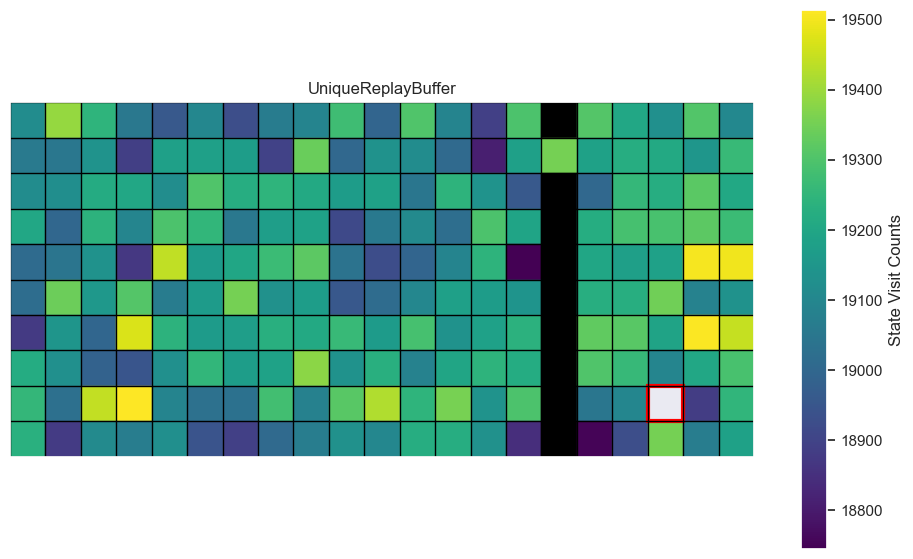

,state_key,transition_details,count,replay_buffer_type
0,"(4, 6)","((4, 5), 1, 0, (4, 6), False)",6013,ReplayBuffer
1,"(3, 17)","((3, 16), 1, 0, (3, 17), False)",4504,ReplayBuffer
2,"(4, 8)","((5, 8), 0, 0, (4, 8), False)",5447,ReplayBuffer
3,"(1, 9)","((1, 8), 1, 0, (1, 9), False)",5411,ReplayBuffer
4,"(4, 12)","((4, 11), 1, 0, (4, 12), False)",5275,ReplayBuffer
...,...,...,...,...
1595,"(9, 14)","((9, 14), 2, 0, (9, 14), False)",4649,UniqueReplayBuffer
1596,"(9, 18)","((9, 17), 1, 0, (9, 18), False)",4701,UniqueReplayBuffer
1597,"(9, 17)","((9, 18), 3, 0, (9, 17), False)",4653,UniqueReplayBuffer
1598,"(8, 17)","((9, 17), 0, 0, (8, 17), False)",4643,UniqueReplayBuffer


In [76]:
def process_denormalized_data(config, path):
    rows = config["rows"]
    cols = config["cols"]
    rb_type = config["replay_buffer"].get("type")
    
    grid_shape = (rows, cols)

    transition_counter_file_path = os.path.join(path, "experiment_distributions_transition_counter.pkl")

    transition_counter = load_transition_counter(transition_counter_file_path)
    denormalized_counter = denormalize_transition_counter(transition_counter, grid_shape[0], grid_shape[1])
    state_counts = transition_to_state_counter(denormalized_counter)

    data = []
    for (s, a, r, s_prime, d), count in denormalized_counter.items():
        data.append({
            "state_key": s_prime,
            "transition_details": (s, a, r, s_prime, d),
            "count": count,
            "replay_buffer_type": rb_type
        })

    df = pd.DataFrame(data, columns=["state_key", "transition_details", "count", "replay_buffer_type"])

    return df, state_counts, denormalized_counter

def plot_denormalized_gridworld_state_counts(config, path, state_counts, rb_type):
    rows = config["rows"]
    cols = config["cols"]
    terminal_states = config["terminal_states"]
    walls = set(config.get("walls", []))
    
    grid_shape = (rows, cols)

    draw_gridworld_with_state_counts(grid_shape, 
                                     state_counts, 
                                     walls, 
                                     terminal_states,
                                     show_text=False, 
                                     figsize=(12, 7),
                                     title=rb_type)

# Collecting the data into a DataFrame
all_data = []

for key in config_data:
    path = key
    config = config_data[key]
    df, state_counts, denormalized_counter = process_denormalized_data(config, path)
    all_data.append(df)
    
    # Plotting
    plot_denormalized_gridworld_state_counts(config, path, state_counts, config["replay_buffer"].get("type"))

final_df = pd.concat(all_data, ignore_index=True)
final_df


In [77]:
# Sorting and reshaping the DataFrame
sorted_df = final_df.sort_values(by=["state_key"])
reshaped_df = sorted_df.pivot_table(
    index=["state_key", "transition_details"],
    columns="replay_buffer_type",
    values="count",
    fill_value=0
).reset_index()

# Renaming columns to include replay buffer type
reshaped_df.columns = ["state_key", "transition_details"] + [
    f"counts_{col}" for col in reshaped_df.columns[2:]
]

reshaped_df

,state_key,transition_details,counts_ReplayBuffer,counts_UniqueReplayBuffer
0,"(0, 0)","((0, 0), 0, 0, (0, 0), False)",5023.0,4746.0
1,"(0, 0)","((0, 0), 3, 0, (0, 0), False)",5047.0,4669.0
2,"(0, 0)","((0, 1), 3, 0, (0, 0), False)",5365.0,4908.0
3,"(0, 0)","((1, 0), 0, 0, (0, 0), False)",4720.0,4779.0
4,"(0, 1)","((0, 0), 1, 0, (0, 1), False)",4819.0,4746.0
...,...,...,...,...
795,"(9, 19)","((9, 20), 3, 0, (9, 19), False)",866.0,4802.0
796,"(9, 20)","((8, 20), 2, 0, (9, 20), False)",985.0,4906.0
797,"(9, 20)","((9, 19), 1, 0, (9, 20), False)",812.0,4815.0
798,"(9, 20)","((9, 20), 1, 0, (9, 20), False)",757.0,4761.0


In [78]:
state_key_filter_list = [
    (0, 13), (0, 14), 
    (1, 13), (1, 14), 
    (2, 13), (2, 14), 
                         ]  

# Filter the reshaped DataFrame for state keys that are in the provided list
filtered_reshaped_df = reshaped_df[reshaped_df["state_key"].isin(state_key_filter_list)]

filtered_reshaped_df

,state_key,transition_details,counts_ReplayBuffer,counts_UniqueReplayBuffer
52,"(0, 13)","((0, 12), 1, 0, (0, 13), False)",5954.0,4810.0
53,"(0, 13)","((0, 13), 0, 0, (0, 13), False)",5297.0,4713.0
54,"(0, 13)","((0, 14), 3, 0, (0, 13), False)",5359.0,4863.0
55,"(0, 13)","((1, 13), 0, 0, (0, 13), False)",5698.0,4708.0
56,"(0, 14)","((0, 13), 1, 0, (0, 14), False)",5338.0,4692.0
57,"(0, 14)","((0, 14), 0, 0, (0, 14), False)",5182.0,4824.0
58,"(0, 14)","((0, 14), 1, 0, (0, 14), False)",5207.0,4813.0
59,"(0, 14)","((1, 14), 0, 0, (0, 14), False)",4978.0,4736.0
132,"(1, 13)","((0, 13), 2, 0, (1, 13), False)",5679.0,4832.0
133,"(1, 13)","((1, 12), 1, 0, (1, 13), False)",5571.0,4772.0


In [72]:
# Collecting the data into a DataFrame
data = []

for key in config_data:
    path = key
    config = config_data[key]
    denormalized_counter, state_counts, rb_type = plot_denormalized_gridworld_state_counts(config, path)
    
    for state, count in state_counts.items():
        data.append({
            "StateKey": state,
            "TransitionDetails": denormalized_counter,
            "Count": count,
            "ReplayBufferType": rb_type
        })

df = pd.DataFrame(data, columns=["StateKey", "TransitionDetails", "Count", "ReplayBufferType"])

print(df)

201

{(4, 6): 22209,
 (3, 17): 16015,
 (4, 8): 21832,
 (1, 9): 21795,
 (4, 12): 21261,
 (1, 20): 20132,
 (5, 3): 21968,
 (6, 11): 21606,
 (2, 8): 21684,
 (7, 6): 22051,
 (1, 16): 19544,
 (9, 3): 21649,
 (5, 13): 21518,
 (1, 4): 20988,
 (3, 20): 16979,
 (7, 11): 21311,
 (5, 1): 21493,
 (6, 18): 8742,
 (6, 5): 21307,
 (0, 19): 20825,
 (5, 18): 11683,
 (4, 3): 21178,
 (2, 17): 17667,
 (4, 19): 13961,
 (4, 18): 14084,
 (5, 4): 22812,
 (9, 8): 20829,
 (3, 18): 16126,
 (7, 4): 21363,
 (7, 10): 21149,
 (6, 13): 20691,
 (2, 20): 17867,
 (2, 18): 17499,
 (4, 20): 14390,
 (0, 20): 21748,
 (3, 19): 16782,
 (7, 2): 21965,
 (4, 5): 22792,
 (5, 19): 11635,
 (4, 4): 22286,
 (6, 0): 21092,
 (7, 14): 19113,
 (5, 14): 20681,
 (5, 20): 11503,
 (9, 4): 21593,
 (3, 12): 21061,
 (3, 16): 17395,
 (2, 1): 22354,
 (5, 12): 19976,
 (8, 5): 21061,
 (9, 6): 21256,
 (3, 10): 22214,
 (9, 5): 20641,
 (7, 0): 21336,
 (0, 12): 22655,
 (7, 1): 21731,
 (3, 14): 21654,
 (8, 13): 18944,
 (2, 12): 21679,
 (7, 17): 6740,
 (0, 13